# Fixture Modelling

How many goals are PL teams to score and concede in upcoming fixtures?

See here for some more technical details http://web.math.ku.dk/~rolf/teaching/thesis/DixonColes.pdf

## Setup

In [1]:
import pandas as pd
from datetime import timezone
import numpy as np
import scipy.stats
import scipy.optimize
import seaborn as sns

In [27]:
from src.utils.elo import Elo

In [4]:
!cd data/Fantasy-Premier-League && git pull # pull latest data

Already up to date.


## Load data

In [5]:
SEASONS = ['2018-19' ,'2019-20','2020-21', '2021-22',]

In [6]:
BASE = 'data/Fantasy-Premier-League'

In [7]:
combined = pd.DataFrame()
for season in SEASONS:
    df = pd.read_csv(f'{BASE}/data/{season}/fixtures.csv',parse_dates=['kickoff_time'])
    df['season'] = season
    combined = df.append(combined)

In [8]:
teams = pd.read_csv(f'{BASE}/data/master_team_list.csv')

the numbers aren't consistent across seasons so we merge on names and come up with our own numbering

In [9]:
def clean_names(combined, teams):    
    with_names = combined.copy()
    for suff in ['_h','_a']:
        with_names = with_names.merge(teams.rename(columns={'team':f"team{suff}",
                                                            "team_name":f'team_name{suff}'}),on = ['season',f'team{suff}'],how='left')
    unique_teams = list(set(with_names["team_name_h"]))
    name_mapping = dict(zip(unique_teams,range(len(unique_teams))))
    with_names['team_h'] = with_names.team_name_h.map(name_mapping) 
    with_names['team_a'] = with_names.team_name_a.map(name_mapping)
    with_names['days_since_fixture'] = (pd.Timestamp.utcnow() - with_names['kickoff_time']).dt.days
    return with_names, name_mapping

In [10]:
df, name_mapping = clean_names(combined, teams)

In [11]:
COLS = ['team_h','team_a','days_since_fixture','team_h_score','team_a_score']

In [12]:
results = df.loc[(df.finished),COLS].copy()
fixtures = df.loc[~df.finished,COLS].copy() 

In [13]:
assert df['team_name_h'].isna().sum() == 0

## Fit model - (1) Dixon-Coles like

We model a game with home/away score (x,y) as being

$\lambda_h = exp(\mu + \gamma + \alpha_{ha} - \alpha_{ad})$

$\lambda_a = exp(\gamma + \alpha_{aa} - \alpha_{hd})$

$p(x,y) = \frac{exp(-\lambda_h)(\lambda_h)^x}{x!} \frac{exp(-\lambda_a)(\lambda_a)^y}{y!}$

Each team has a coefficient for attacking/defending, and there is a fixed effect $\gamma$ and a home-team fixed effect $\mu$. 

In [14]:
def neg_log_likehihood(params, df, discount, n_teams):
    '''
    Based on model above, sum the negative log likelihood, discounted by time
    '''
    mu, gamma, *alpha  = params
    alpha_score = alpha[:n_teams]
    alpha_concede = alpha[n_teams:]
    home = mu +gamma + np.take(alpha_score,df.team_h) - np.take(alpha_concede,df.team_a)
    away = gamma + np.take(alpha_score,df.team_a) - np.take(alpha_concede,df.team_h)
    exp_home = np.exp(home)
    exp_away = np.exp(away)
    neg_log_lik = exp_home - (df["team_h_score"] * home) + exp_away - (df["team_a_score"] * away)
    loss = (np.exp(-discount * df["days_since_fixture"]) * neg_log_lik).sum()
    return loss / df.shape[0]

In [15]:
class DixonColes():
    def __init__(self, name_mapping, discount = 0.01):
        self.name_mapping = name_mapping
        self.n_teams = len(name_mapping)
        self.discount = discount 
        self.params = [0.0 for _ in range(2 + (2*self.n_teams))]
    
    def fit(self, X): 
        '''
        Minimise negative log-likelihood
        '''
        res = scipy.optimize.minimize(
            fun=neg_log_likehihood,
            x0=self.params,
            args=(X, self.discount, self.n_teams),
        )
        mu, gamma, *alpha = res['x']
        alpha_score = alpha[:self.n_teams]
        alpha_concede = alpha[self.n_teams:]
        return mu, gamma, alpha_score, alpha_concede
        


In [16]:
mu, gamma, alpha_score, alpha_concede =  DixonColes(name_mapping).fit(results)

In [17]:
mu

0.13990353010034517

In [18]:
form = pd.DataFrame(data=[name_mapping.keys(),alpha_score, alpha_concede]).T
form.columns = ['team', 'attack','defence']

In [19]:
form['total'] = form.attack + form.defence

This seams like a reasonable form ranking. I think the model is overrating Brentford a bit having never seen them before.

In [20]:
(form
 .iloc[list(set(fixtures.team_h))]
 .sort_values(by='total',ascending=False))

,team,attack,defence,total
2,Man City,0.626605,0.798528,1.42513
16,Chelsea,0.50908,0.906734,1.41581
11,Liverpool,0.785921,0.359388,1.14531
13,Brentford,0.343186,0.446543,0.789728
1,Man Utd,0.429142,0.0237249,0.452867
17,West Ham,0.37529,0.0762799,0.45157
5,Leicester,0.489116,-0.312347,0.176769
24,Arsenal,0.152905,0.0169583,0.169863
19,Aston Villa,0.240331,-0.0781801,0.162151
20,Brighton,-0.266611,0.423489,0.156878


## Fit Model (2) - ELO

In [29]:
results['outcome'] =(np.clip(results['team_h_score'] -results['team_a_score'],-1,1) + 1) / 2

In [30]:
results = results.sort_values(by='days_since_fixture',ascending=False)

In [31]:
elo =Elo(results,k_factor=35)
historic_elo, elo_ratings =elo.process_all_fixtures()

## Plot elo over time

In [32]:
inv_mapping = {v:k for k,v in name_mapping.items()}

In [33]:
historic_elo['name'] = historic_elo.team_h.map(inv_mapping)

In [34]:
historic_elo['neg_days_since_fixture'] = historic_elo['days_since_fixture'] * -1

In [35]:
filtered = historic_elo.loc[historic_elo.name.isin(['Chelsea', 'Man City', 'Liverpool','West Ham', 'Man Utd'])]

<AxesSubplot:xlabel='neg_days_since_fixture', ylabel='elo'>

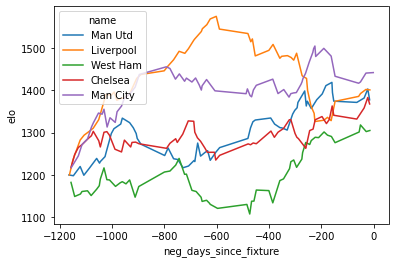

In [36]:
sns.lineplot(data=filtered, hue='name', y='elo', x='neg_days_since_fixture')

In [37]:
form['elo'] =pd.Series(elo_ratings).sort_index()

In [38]:
form.iloc[list(set(fixtures.team_h))].sort_values(by='total',ascending=False)


,team,attack,defence,total,elo
2,Man City,0.626605,0.798528,1.42513,1446.125672
16,Chelsea,0.50908,0.906734,1.41581,1386.570849
11,Liverpool,0.785921,0.359388,1.14531,1408.123835
13,Brentford,0.343186,0.446543,0.789728,1235.542653
1,Man Utd,0.429142,0.0237249,0.452867,1347.836367
17,West Ham,0.37529,0.0762799,0.45157,1300.295277
5,Leicester,0.489116,-0.312347,0.176769,1259.334645
24,Arsenal,0.152905,0.0169583,0.169863,1293.271579
19,Aston Villa,0.240331,-0.0781801,0.162151,1219.037562
20,Brighton,-0.266611,0.423489,0.156878,1230.090834


## Map form onto fixtures

In [39]:
CURRENT_GAMEWEEK = 8 # I should probably calculate this from fixtures

map on the expected scoring rates

In [40]:
fixtures['score'] = np.exp(mu +gamma + np.take(alpha_score,fixtures.team_h) - np.take(alpha_concede,fixtures.team_a))
fixtures['opp_score'] = np.exp(gamma + np.take(alpha_score,fixtures.team_a) - np.take(alpha_concede,fixtures.team_h))

In [41]:
fixtures['elo_win'] =fixtures.apply(lambda row: elo.win_prob(row['team_h'],row['team_a']),axis=1)

In [42]:
fixtures['team'] = fixtures['team_h'].map(inv_mapping)
fixtures['opp'] = fixtures['team_a'].map(inv_mapping)

We flip home and away fixtures to have all fixtures for all teams in long format

In [43]:
upcoming_difficulties = fixtures[['team','opp','score','elo_win','opp_score','days_since_fixture']]

In [44]:
flipped_difficulties = upcoming_difficulties.copy().rename(columns={'team':'opp',
                                                                    'opp':'team',
                                                                    'score':'opp_score',
                                                                    'opp_score':'score',})
flipped_difficulties['elo_win'] = 1 -flipped_difficulties['elo_win']

In [45]:
assert (upcoming_difficulties.groupby('team')['opp'].count() + upcoming_difficulties.groupby('opp')['team'].count()).max() == 38 - CURRENT_GAMEWEEK

In [46]:
combined_difficulties = upcoming_difficulties.append(flipped_difficulties)

In [47]:
combined_difficulties['gw'] = combined_difficulties.reset_index().sort_values(by='days_since_fixture').groupby('team').days_since_fixture.cumcount() +1 + CURRENT_GAMEWEEK

In [48]:
score_pivot = pd.pivot_table(data=combined_difficulties,values='score',
                             index='team',columns='gw')

In [49]:
defend_pivot = pd.pivot_table(data=combined_difficulties,values='opp_score',
                              index='team',columns='gw')

In [50]:
elo_pivot = pd.pivot_table(data=combined_difficulties,values='elo_win',
                              index='team',columns='gw')

Filter the data for the next n weeks

In [51]:
N = 5

In [52]:
for outcome in ['score','opp_score','elo_win']:
    print(outcome)
    pivot = pd.pivot_table(data=combined_difficulties,values=outcome,
                             index='team',columns='gw')
    n_week = pivot.iloc[:,:N].copy()
    n_week['avg'] = n_week.mean(axis=1)
    sort_dir = outcome == 'opp_score'
    display(n_week
     .sort_values(by='avg',ascending=sort_dir) 
     .style.background_gradient(cmap='Blues'))

score


gw,9,10,11,12,13,avg
team,,,,,,
Chelsea,2.352973,3.267509,1.990100,2.710755,1.959755,2.456218
Liverpool,2.554858,1.489335,2.424055,2.236383,3.569497,2.454825
Man City,1.460701,2.204156,2.178595,1.875189,2.570463,2.057821
Brentford,1.996568,1.939043,1.993288,2.768024,1.436377,2.026660
West Ham,1.738231,1.876241,1.053163,1.555287,2.858332,1.816251
Man Utd,1.111433,2.109864,0.716420,2.987527,1.830038,1.751057
Aston Villa,1.490591,1.221338,1.541984,0.863068,2.473500,1.518096
Leicester,1.244052,1.662054,2.234940,0.682685,1.515253,1.467797
Arsenal,1.306016,1.898478,1.970535,0.969783,0.888840,1.406730


opp_score


gw,9,10,11,12,13,avg
team,,,,,,
Chelsea,0.101162,0.465826,0.325618,0.682685,0.570000,0.429058
Man City,0.357278,0.635139,0.716420,0.587576,0.588899,0.577062
Brentford,1.244052,0.448546,0.160278,0.738044,0.888840,0.695952
Liverpool,1.111433,0.637501,1.053163,0.969783,0.152043,0.784785
Southampton,0.820077,0.700524,1.541984,0.221515,1.154670,0.887754
Brighton,1.460701,1.489335,0.868668,0.863068,0.459007,1.028156
Aston Villa,1.306016,1.876241,0.921245,0.987449,0.744766,1.167143
Everton,0.765861,0.857360,1.455193,1.875189,0.947339,1.180189
Wolves,0.864018,1.170403,1.099969,1.555287,1.515253,1.240986


elo_win


gw,9,10,11,12,13,avg
team,,,,,,
Chelsea,0.907742,0.806390,0.834063,0.675338,0.760146,0.796736
Man City,0.776189,0.817023,0.637793,0.752767,0.709770,0.738709
Liverpool,0.585900,0.735914,0.650380,0.659517,0.917620,0.709866
Brentford,0.465814,0.678157,0.804866,0.635835,0.417678,0.600470
Man Utd,0.414100,0.581387,0.362207,0.809932,0.668305,0.567186
West Ham,0.513697,0.614853,0.349620,0.638488,0.717091,0.566750
Arsenal,0.605235,0.548684,0.756847,0.340483,0.582322,0.566714
Southampton,0.579394,0.593422,0.418237,0.729475,0.371960,0.538498
Everton,0.711349,0.573184,0.445429,0.247233,0.628040,0.521047
